# 1 Introduction

We perform simple diagnostic tests of our MOCHIS software. These include 

- checking that our implementation agrees with standard two-sample tests when applicable;
- checking that (our implementation in R of) the test controls Type I Error

In [2]:
# Setup

import scanpy
import numpy as np
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from main_draft0 import *
import scipy
import statistics
import os
import sys

#https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print#:~:text=If%20you%20don't%20want,the%20top%20of%20the%20file.
# Disable

    
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# 2 Agreement with Standard Tests

A special case of MOCHIS is the widely used two-sample test of stochastic dominance, known as the Mann-Whitney or Wilcoxon rank sum test (see [explanation](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) and [example R code](http://www.sthda.com/english/wiki/unpaired-two-samples-wilcoxon-test-in-r)). 

We compare our implementation of MOCHIS with `scipy.stats.mannwhitneyu`, which is the standard choice provided by base R. We construct our two samples of size $n$ and $k$ by drawing each sample i.i.d. from a standard Gaussian distribution before taking an absolute value (i.e., $\boldsymbol{z}=(|z_1|,\ldots,|z_k|)$ where $z_i\overset{\text{iid}}{\sim}N(0,1)$). We vary $(n,k)\in\{(50,10),(50,20),(50,50), (100,10),(100,20),(100,50), (500,10),(500,20),(500,50)\}$, effectively allowing our experiment to cover our implementation of both the resampling routine for small $k$ and the Gaussian approximation for large $k$ and $n$. 

In [97]:
%%capture
# Helper function for computing p-values

def get_p_values(n, k, n_draws = 800):
    # create dataframe to return
    to_return = pd.DataFrame(columns=['SEED', 'WILCOX', 'MOCHIS'])
    # Generate n_draws p-values using both MOCHIS and wilcox test
    for seed in range(n_draws):
        # set seed
        np.random.seed(seed)
        # Generate null samples (X, Y)
        x0 = [abs(np.random.normal()) for i in range(k)]
        y0 = [abs(np.random.normal()) for i in range(n)]
        
        
        to_return = pd.concat([to_return, pd.DataFrame([{
            "SEED": seed,
            "WILCOX": scipy.stats.mannwhitneyu(x=x0, y=y0, alternative='two-sided',use_continuity=True,  method='asymptotic').pvalue,
            "MOCHIS": mochis_py(x = x0,p = 1,wList = range(k, -1, -1),alternative = "two.sided",approx = "resample",n_mom = 100,y = y0)
        }])])
        
    return to_return
    
# Compute p-values

        

if not os.path.exists('mw_vs_mochis'):
    os.mkdir(os.path.join("mw_vs_mochis"))
for n in [50, 100, 500]:
    for k in [10, 20, 50]:
        combination = "n"+str(n)+"k"+str(k)
        results = get_p_values(n, k)
        results.to_csv("mw_vs_mochis/"+combination+".csv")
            
    
    
    

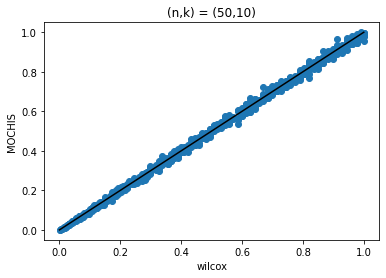

The root mean squared difference in p-values for (n,k) = ( 50 , 10 ) is  0.0001493634534130693


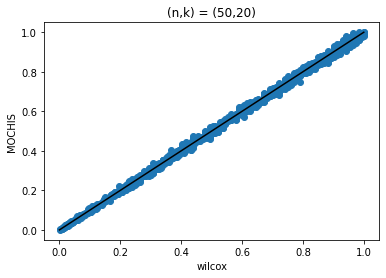

The root mean squared difference in p-values for (n,k) = ( 50 , 20 ) is  0.0001563304835542237


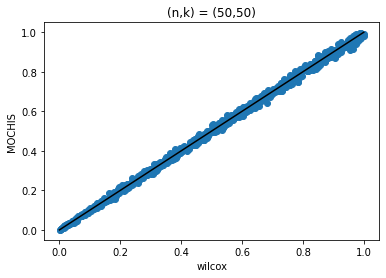

The root mean squared difference in p-values for (n,k) = ( 50 , 50 ) is  0.00013896995710707376


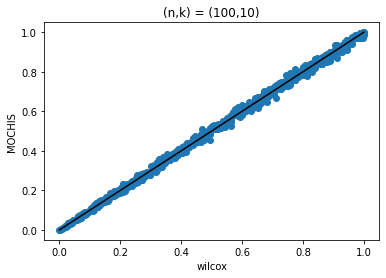

The root mean squared difference in p-values for (n,k) = ( 100 , 10 ) is  0.00014141465627909799


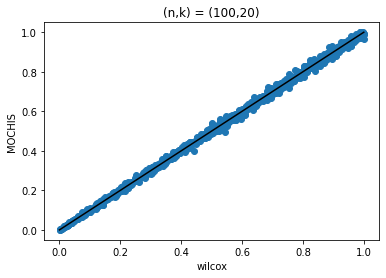

The root mean squared difference in p-values for (n,k) = ( 100 , 20 ) is  0.00014089431748578614


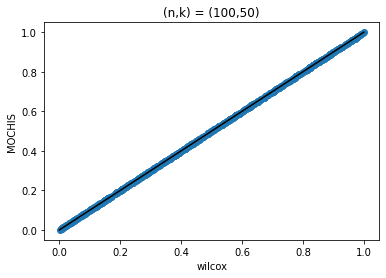

The root mean squared difference in p-values for (n,k) = ( 100 , 50 ) is  1.411850603877463e-06


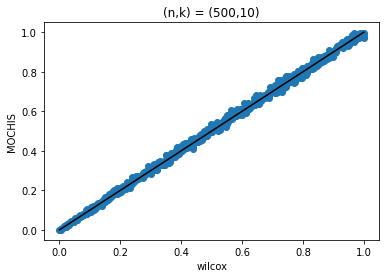

The root mean squared difference in p-values for (n,k) = ( 500 , 10 ) is  0.00014454151494985897


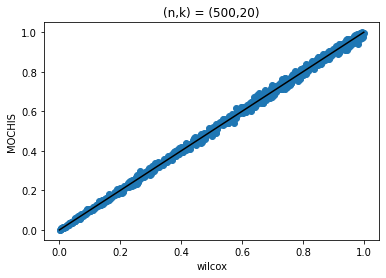

The root mean squared difference in p-values for (n,k) = ( 500 , 20 ) is  0.00013760487436642856


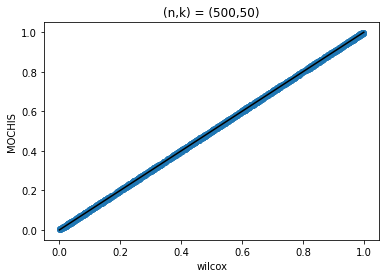

The root mean squared difference in p-values for (n,k) = ( 500 , 50 ) is  7.972288100485467e-08


In [98]:
# Load data and generate plots
#mw_vs_mochis = pd.read_csv("mw_vs_mochis.csv")

# Plot
for n in [50, 100, 500]:
    for k in [10, 20, 50]:
        combination = "n"+str(n)+"k"+str(k)
        wilcox_values = pd.read_csv("mw_vs_mochis/"+combination+".csv")['WILCOX']
        mochis_values = pd.read_csv("mw_vs_mochis/"+combination+".csv")['MOCHIS']
        plt.scatter(wilcox_values, mochis_values)
        plt.plot([0,1],[0,1], color="black")
        plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
        plt.xlabel("wilcox")
        plt.ylabel("MOCHIS")
        plt.show()
        rmse = np.mean((wilcox_values-mochis_values)**2)
        print("The root mean squared difference in p-values for (n,k) = (", str(n), ",", str(k),") is ", str(rmse))





# 3 Type I Error Control

We simulate samples $(X,Y)$, with $X\in\mathbb{R}^k$ and $Y\in\mathbb{R}^n$ and $k\leqslant n$. We draw each element of $X$ and $Y$ from the same distribution to match the null hypothesis. By varying the values of $(k,n)$, we examine the control of Type I Error of MOCHIS. This also allows examination of the numerical performance of the various approximations (e.g., large $n$, large $n$ and $k$) described in the paper. 

In [3]:
def get_FPR(n, # length of y
            k, # length of x
            p, # choice of exponent
            w_vec, # choice of weight vector
            path, # where to save plots
            plot = False, n_draws = 800):
    # Enforce length(w_vec) = k+1
    assert len(w_vec) == k+1, "Length of w_vec must be (k+1)."
    
    # Generate n_draws p-values to computer FPP
    def generate_n_draws(k, n, p, wList):
        x0 = [abs(np.random.normal()) for i in range(k)]
        y0 = [abs(np.random.normal()) for i in range(n)]
        with HiddenPrints():
            return mochis_py(x=x0,
                             p=p, 
                             wList=wList,
                             alternative="two.sided", 
                             approx="resample", 
                             n_mom=100, 
                             y=y0)
        
   
    p_values_vec = [generate_n_draws(k, n, p, w_vec) for i in range(n_draws)]
    
    # Compute variance of empirical distribution of p-values
    # Should be close to 1/12 
    emp_var = np.var(p_values_vec)
    emp_mean = np.mean(p_values_vec)
    
    # Compute FPP vector (i.e., for each alpha, what's the FPP?)
    alpha_vec = np.linspace(0, 1, 201)
    
    fpp_vec = []
    for alpha in alpha_vec:
        fpp_vec.append(sum(i<=alpha for i in p_values_vec) / len(p_values_vec))
    
    #fpp_df = pd.DataFrame(data={'ALPHA':alpha_vec, 'FPP':fpp_vec})
    fpp_df = {'ALPHA':alpha_vec, 'FPP':fpp_vec}
    
    if plot:
        print("Generating plot for (n,k,p) = (", n,", ",k,", ",p,")")
        plt.figure()
        plt.plot(alpha_vec, fpp_vec)
        plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
        plt.xlabel("Alpha")
        plt.ylabel("False Positive Proportion")
        plt.plot([0, 1], [0, 1], color='black')
        plt.show()
        
        
    # Return fpp_df and emp_var
    return {"EMP_MEAN": emp_mean, "EMP_VAR": emp_var, "FPP_DF_ALPHA": alpha_vec, "FPP_DF_FPP": fpp_vec, "PVALUES": p_values_vec}

    

           

## 3.1 Small $\boldsymbol{n}$ and small $\boldsymbol{k}$
Check for Mann-Whitney. 

Generating Mann-Whitney plot for (n,k) = ( 20 ,  10 )
Empirical mean =  0.5085655 . Empirical variance =  0.08568890000974999
Generating plot for (n,k,p) = ( 20 ,  10 ,  )


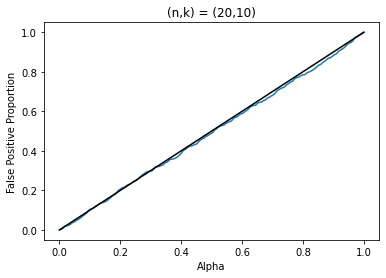

Generating Mann-Whitney plot for (n,k) = ( 30 ,  10 )
Empirical mean =  0.521203 . Empirical variance =  0.07887289199099999
Generating plot for (n,k,p) = ( 30 ,  10 ,  )


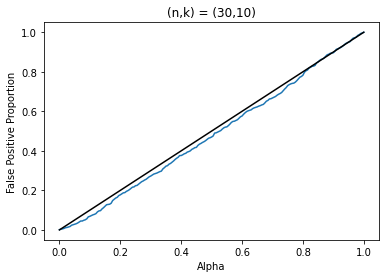

Generating Mann-Whitney plot for (n,k) = ( 40 ,  10 )
Empirical mean =  0.48823750000000005 . Empirical variance =  0.08515128739375001
Generating plot for (n,k,p) = ( 40 ,  10 ,  )


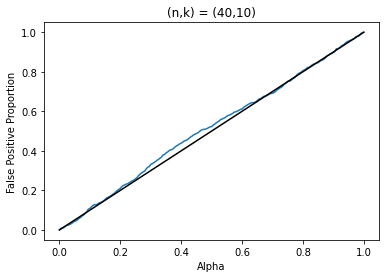

Generating Mann-Whitney plot for (n,k) = ( 20 ,  20 )
Empirical mean =  0.4972285 . Empirical variance =  0.07932879338775
Generating plot for (n,k,p) = ( 20 ,  20 ,  )


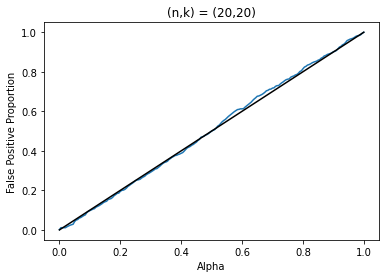

Generating Mann-Whitney plot for (n,k) = ( 30 ,  20 )
Empirical mean =  0.49531 . Empirical variance =  0.08259249309999998
Generating plot for (n,k,p) = ( 30 ,  20 ,  )


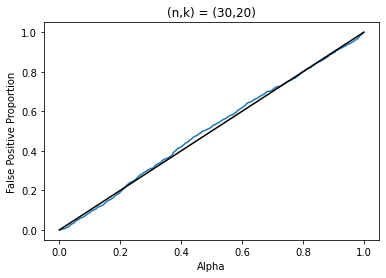

Generating Mann-Whitney plot for (n,k) = ( 40 ,  20 )
Empirical mean =  0.511856 . Empirical variance =  0.083556887664
Generating plot for (n,k,p) = ( 40 ,  20 ,  )


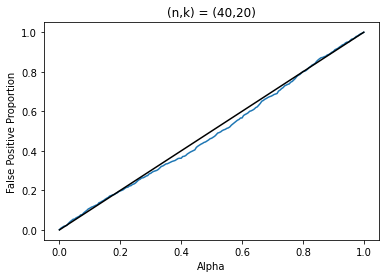

k exceeds n, skipping...
k exceeds n, skipping...
Generating Mann-Whitney plot for (n,k) = ( 40 ,  40 )
Empirical mean =  0.5101425 . Empirical variance =  0.08625239589374999
Generating plot for (n,k,p) = ( 40 ,  40 ,  )


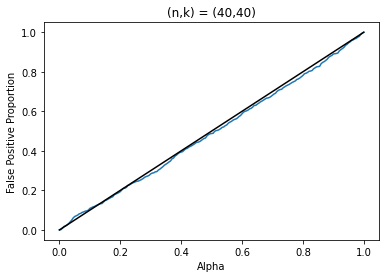

In [4]:
# Mann-Whitney
n_vec = [20,30,40]
k_vec = [10,20,40]
diagnostic_list = pd.DataFrame()



for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF_ALPHA", "FPP_DF_FPP", "PVALUES"])
    k = k_vec[i]
    wList = [i for i in range(k,-1,-1)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating Mann-Whitney plot for (n,k) = (", n,", ",k,")")
            
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=False, path="type_one_small_n_small_k")
            
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_mw_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
            

    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("small_k_small_n_mw_resample.csv")
            
   
            
        

Check for dispersion shift

Generating dispersion shift plot for (n,k) = ( 10 ,  10 )
Generating plot for (n,k,p) = ( 10 ,  10 ,  1 )


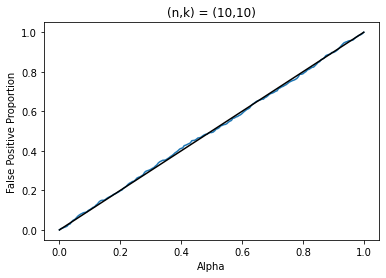

Empirical mean =  0.49985100000000005 . Empirical variance =  0.08514167459899999
Generating plot for (n,k,p) = ( 10 ,  10 ,  )


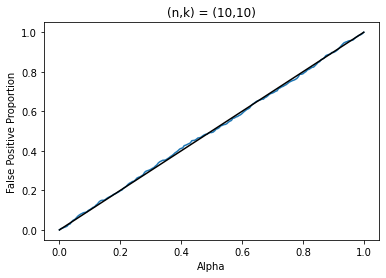

Generating dispersion shift plot for (n,k) = ( 20 ,  10 )
Generating plot for (n,k,p) = ( 20 ,  10 ,  1 )


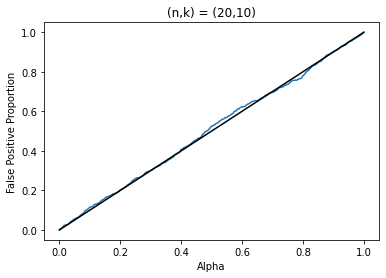

Empirical mean =  0.49646700000000005 . Empirical variance =  0.085218025111
Generating plot for (n,k,p) = ( 20 ,  10 ,  )


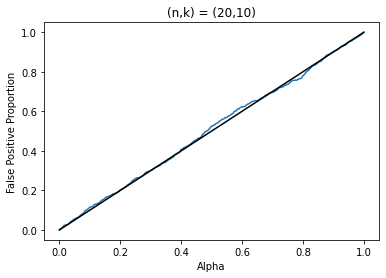

Generating dispersion shift plot for (n,k) = ( 40 ,  10 )
Generating plot for (n,k,p) = ( 40 ,  10 ,  1 )


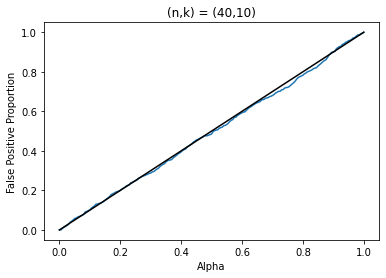

Empirical mean =  0.506016 . Empirical variance =  0.08534254694400001
Generating plot for (n,k,p) = ( 40 ,  10 ,  )


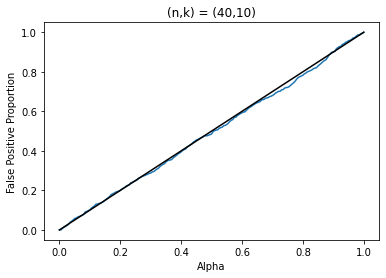

k exceeds n, skipping...
Generating dispersion shift plot for (n,k) = ( 20 ,  20 )
Generating plot for (n,k,p) = ( 20 ,  20 ,  1 )


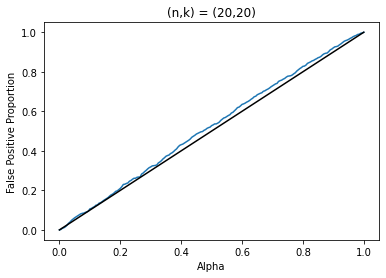

Empirical mean =  0.4809435000000001 . Empirical variance =  0.08024041200775
Generating plot for (n,k,p) = ( 20 ,  20 ,  )


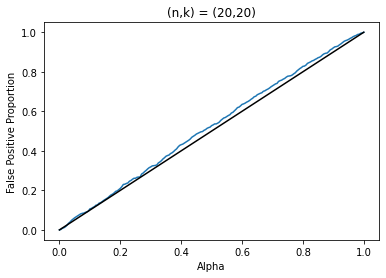

Generating dispersion shift plot for (n,k) = ( 40 ,  20 )
Generating plot for (n,k,p) = ( 40 ,  20 ,  1 )


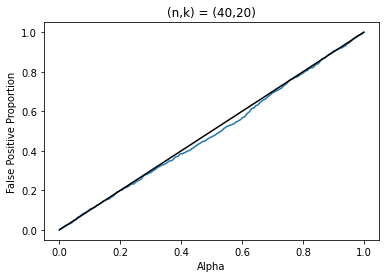

Empirical mean =  0.5106335 . Empirical variance =  0.08394085527775
Generating plot for (n,k,p) = ( 40 ,  20 ,  )


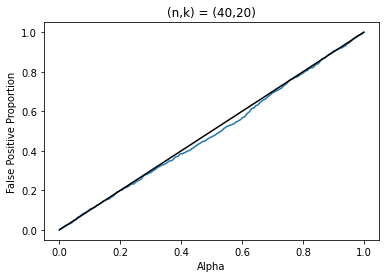

k exceeds n, skipping...
k exceeds n, skipping...
Generating dispersion shift plot for (n,k) = ( 40 ,  40 )
Generating plot for (n,k,p) = ( 40 ,  40 ,  1 )


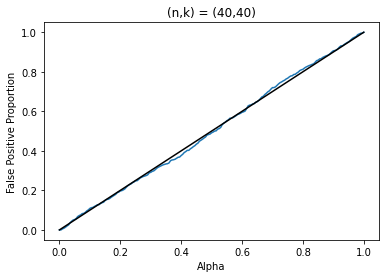

Empirical mean =  0.500738 . Empirical variance =  0.08074339335599999
Generating plot for (n,k,p) = ( 40 ,  40 ,  )


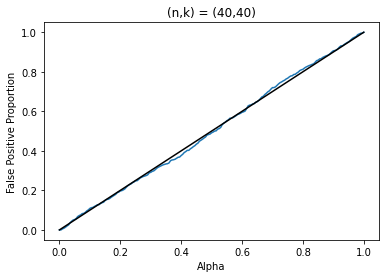

In [5]:
# Scale-shift alternative
n_vec = [10,20,40]
k_vec = [10,20,40]
diagnostic_list = pd.DataFrame()



for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF", "PVALUES"])
    k = k_vec[i]
    wList = [(x/(k+1) - 0.5)**2 for x in range(1, k+2)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating dispersion shift plot for (n,k) = (", n,", ",k,")")
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=True, path="type_one_small_n_small_k_dispersion")
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_quad_kernel_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
        
    
    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("small_k_small_n_quad_kernel_resample.csv")
            

## 3.2 Large $\boldsymbol{n}$ and small $\boldsymbol{k}$


Generating Mann-Whitney plot for (n,k) = ( 100 ,  10 )
Generating plot for (n,k,p) = ( 100 ,  10 ,  1 )


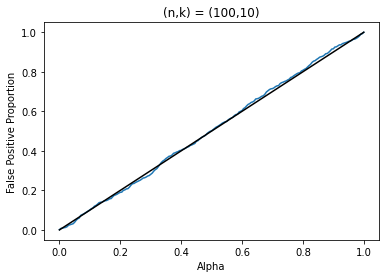

Empirical mean =  0.49713999999999997 . Empirical variance =  0.0798247376
Generating plot for (n,k,p) = ( 100 ,  10 ,  )


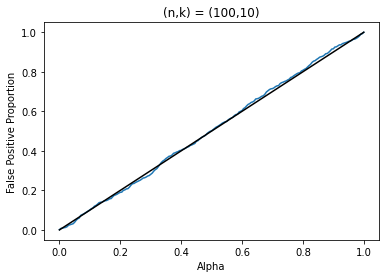

Generating Mann-Whitney plot for (n,k) = ( 200 ,  10 )
Generating plot for (n,k,p) = ( 200 ,  10 ,  1 )


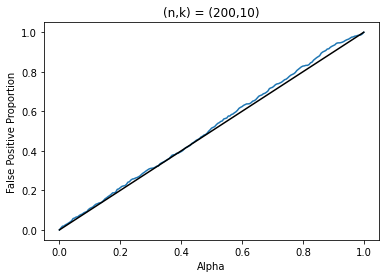

Empirical mean =  0.4866715 . Empirical variance =  0.07990563008775001
Generating plot for (n,k,p) = ( 200 ,  10 ,  )


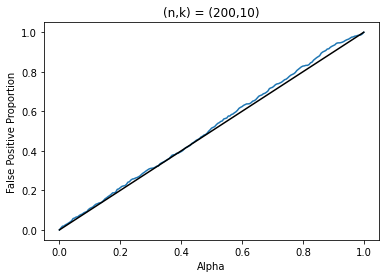

Generating Mann-Whitney plot for (n,k) = ( 500 ,  10 )
Generating plot for (n,k,p) = ( 500 ,  10 ,  1 )


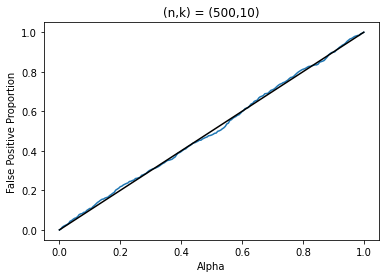

Empirical mean =  0.4980525 . Empirical variance =  0.08405936944375
Generating plot for (n,k,p) = ( 500 ,  10 ,  )


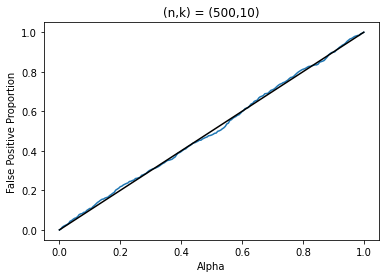

Generating Mann-Whitney plot for (n,k) = ( 100 ,  20 )
Generating plot for (n,k,p) = ( 100 ,  20 ,  1 )


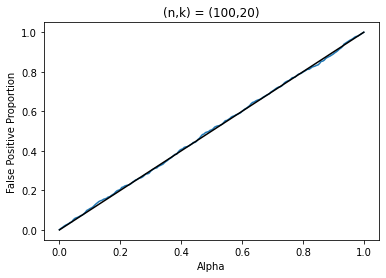

Empirical mean =  0.498606 . Empirical variance =  0.08460912716399999
Generating plot for (n,k,p) = ( 100 ,  20 ,  )


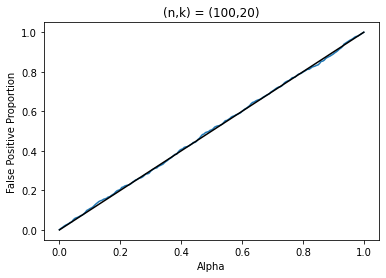

Generating Mann-Whitney plot for (n,k) = ( 200 ,  20 )
Generating plot for (n,k,p) = ( 200 ,  20 ,  1 )


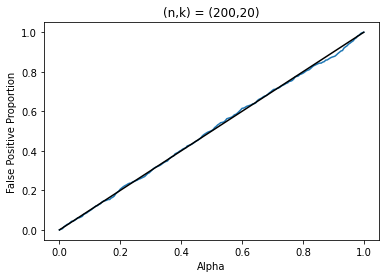

Empirical mean =  0.5017874999999999 . Empirical variance =  0.08485693904375
Generating plot for (n,k,p) = ( 200 ,  20 ,  )


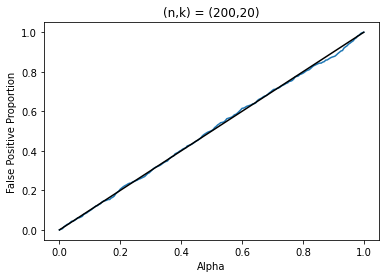

Generating Mann-Whitney plot for (n,k) = ( 500 ,  20 )
Generating plot for (n,k,p) = ( 500 ,  20 ,  1 )


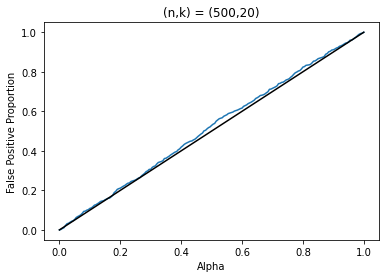

Empirical mean =  0.48680899999999994 . Empirical variance =  0.08203262391900001
Generating plot for (n,k,p) = ( 500 ,  20 ,  )


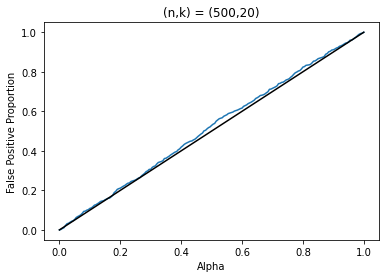

Generating Mann-Whitney plot for (n,k) = ( 100 ,  40 )
Generating plot for (n,k,p) = ( 100 ,  40 ,  1 )


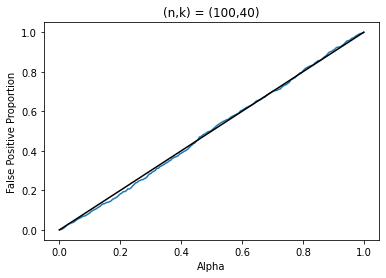

Empirical mean =  0.503812 . Empirical variance =  0.079473317456
Generating plot for (n,k,p) = ( 100 ,  40 ,  )


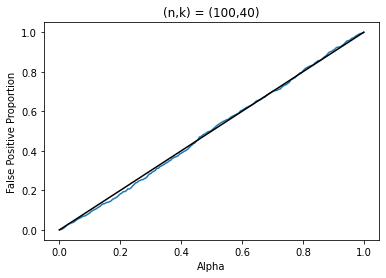

Generating Mann-Whitney plot for (n,k) = ( 200 ,  40 )
Generating plot for (n,k,p) = ( 200 ,  40 ,  1 )


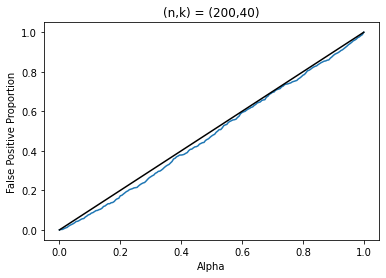

Empirical mean =  0.5197350000000001 . Empirical variance =  0.080469563375
Generating plot for (n,k,p) = ( 200 ,  40 ,  )


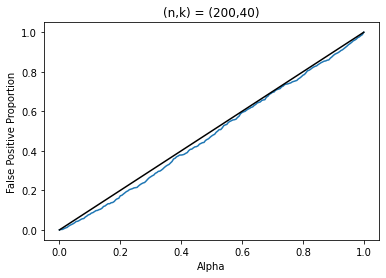

Generating Mann-Whitney plot for (n,k) = ( 500 ,  40 )
Generating plot for (n,k,p) = ( 500 ,  40 ,  1 )


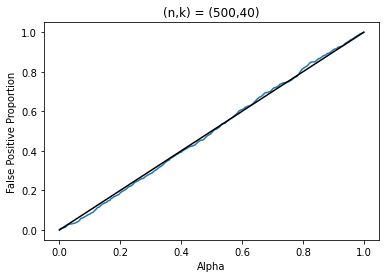

Empirical mean =  0.5022995 . Empirical variance =  0.07855927729975001
Generating plot for (n,k,p) = ( 500 ,  40 ,  )


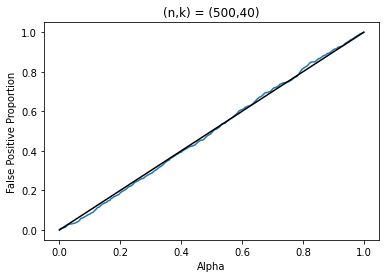

In [6]:
# Mann-Whitney
n_vec = [100,200,500]
k_vec = [10,20,40]
diagnostic_list = pd.DataFrame()


for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF_ALPHA", "FPP_DF_FPP", "PVALUES"])
    k = k_vec[i]
    wList = [i for i in range(k,-1,-1)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating Mann-Whitney plot for (n,k) = (", n,", ",k,")")
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=True, path="type_one_large_n_small_k")
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_mw_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
            
        
    
    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("small_k_large_n_mw_resample.csv")
            
            
            
        

Check for dispersion shift

Generating dispersion shift plot for (n,k) = ( 100 ,  10 )
Generating plot for (n,k,p) = ( 100 ,  10 ,  1 )


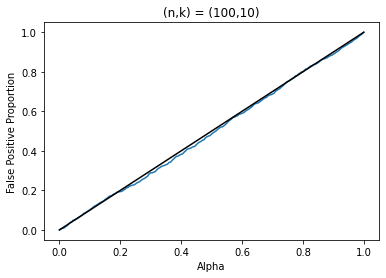

Empirical mean =  0.5077704999999999 . Empirical variance =  0.08343094192975001
Generating plot for (n,k,p) = ( 100 ,  10 ,  )


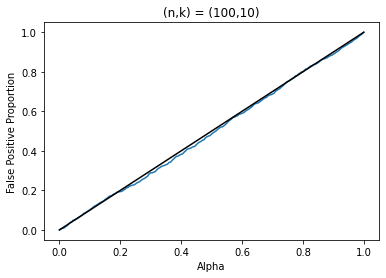

Generating dispersion shift plot for (n,k) = ( 200 ,  10 )
Generating plot for (n,k,p) = ( 200 ,  10 ,  1 )


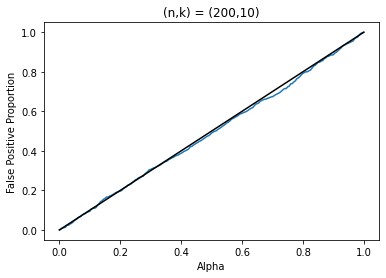

Empirical mean =  0.50751 . Empirical variance =  0.0856097499
Generating plot for (n,k,p) = ( 200 ,  10 ,  )


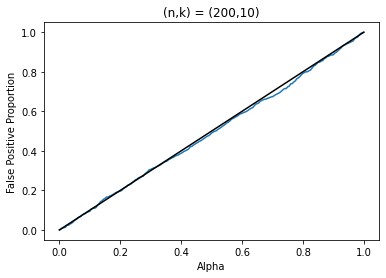

Generating dispersion shift plot for (n,k) = ( 500 ,  10 )
Generating plot for (n,k,p) = ( 500 ,  10 ,  1 )


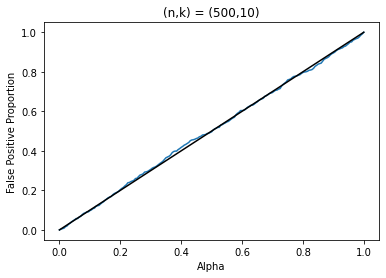

Empirical mean =  0.498959 . Empirical variance =  0.085465381119
Generating plot for (n,k,p) = ( 500 ,  10 ,  )


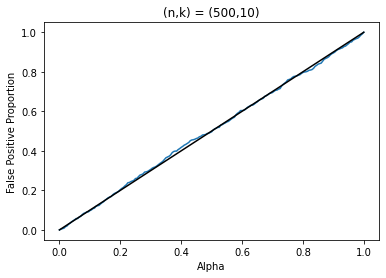

Generating dispersion shift plot for (n,k) = ( 100 ,  20 )
Generating plot for (n,k,p) = ( 100 ,  20 ,  1 )


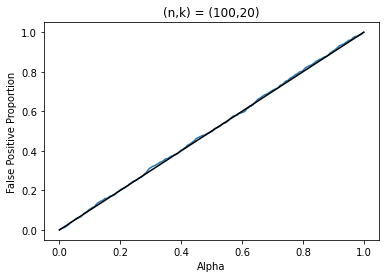

Empirical mean =  0.49628950000000005 . Empirical variance =  0.08267936318975
Generating plot for (n,k,p) = ( 100 ,  20 ,  )


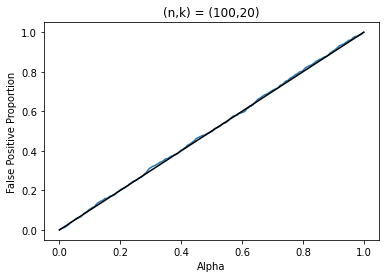

Generating dispersion shift plot for (n,k) = ( 200 ,  20 )
Generating plot for (n,k,p) = ( 200 ,  20 ,  1 )


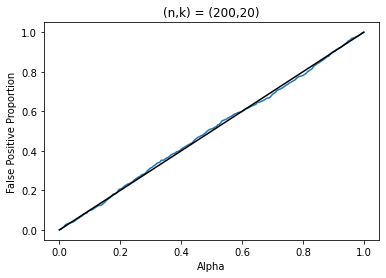

Empirical mean =  0.49955150000000004 . Empirical variance =  0.08500478904775001
Generating plot for (n,k,p) = ( 200 ,  20 ,  )


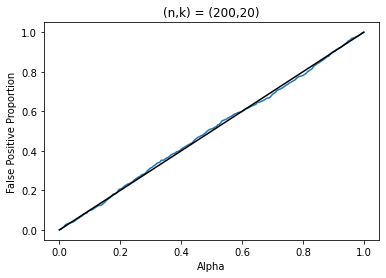

Generating dispersion shift plot for (n,k) = ( 500 ,  20 )
Generating plot for (n,k,p) = ( 500 ,  20 ,  1 )


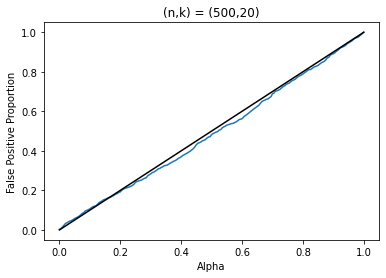

Empirical mean =  0.5129104999999999 . Empirical variance =  0.08528496038975
Generating plot for (n,k,p) = ( 500 ,  20 ,  )


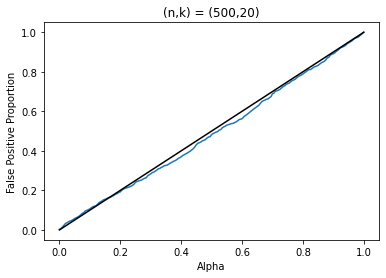

Generating dispersion shift plot for (n,k) = ( 100 ,  40 )
Generating plot for (n,k,p) = ( 100 ,  40 ,  1 )


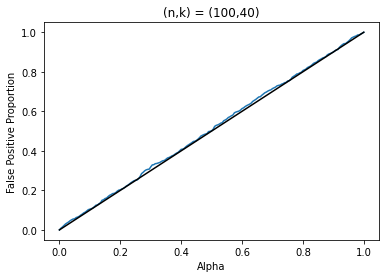

Empirical mean =  0.49242 . Empirical variance =  0.0833469032
Generating plot for (n,k,p) = ( 100 ,  40 ,  )


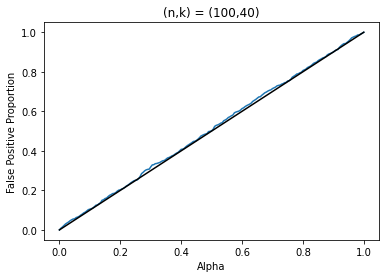

Generating dispersion shift plot for (n,k) = ( 200 ,  40 )
Generating plot for (n,k,p) = ( 200 ,  40 ,  1 )


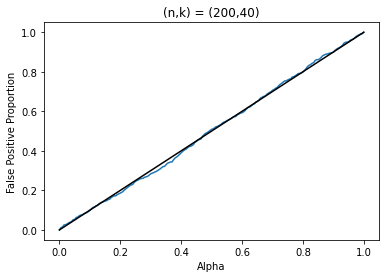

Empirical mean =  0.501113 . Empirical variance =  0.08092010203099999
Generating plot for (n,k,p) = ( 200 ,  40 ,  )


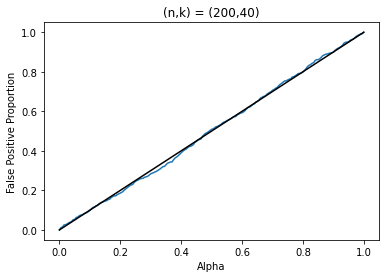

Generating dispersion shift plot for (n,k) = ( 500 ,  40 )
Generating plot for (n,k,p) = ( 500 ,  40 ,  1 )


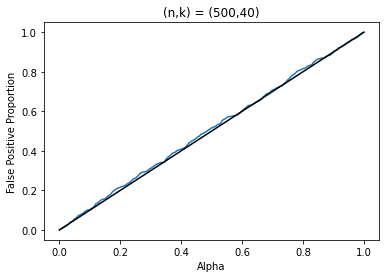

Empirical mean =  0.491872 . Empirical variance =  0.084344622816
Generating plot for (n,k,p) = ( 500 ,  40 ,  )


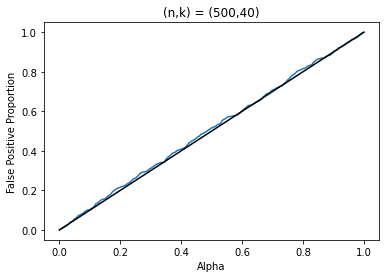

In [7]:
# Scale-shift alternative
n_vec = [100,200,500]
k_vec = [10,20,40]
diagnostic_list = pd.DataFrame()



for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF", "PVALUES"])
    k = k_vec[i]
    wList = [(x/(k+1) - 0.5)**2 for x in range(1, k+2)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating dispersion shift plot for (n,k) = (", n,", ",k,")")
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=True, path="type_one_large_n_small_k_dispersion")
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_quad_kernel_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
            
        
    
    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("small_k_large_n_quad_kernel_resample.csv")
            
            
            
        
            

## 3.3 Large $\boldsymbol{n}$ and large $\boldsymbol{k}$

Generating Mann-Whitney plot for (n,k) = ( 100 ,  50 )
Generating plot for (n,k,p) = ( 100 ,  50 ,  1 )


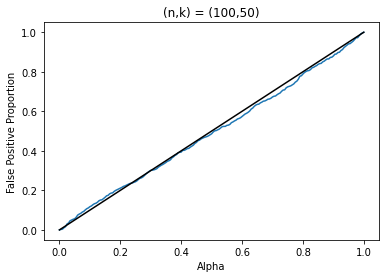

Empirical mean =  0.5084136113041594 . Empirical variance =  0.08897720892146335
Generating plot for (n,k,p) = ( 100 ,  50 ,  )


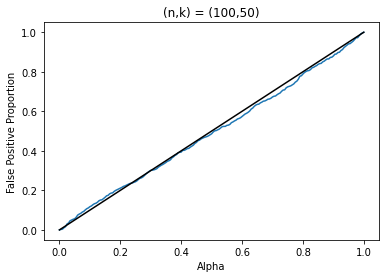

Generating Mann-Whitney plot for (n,k) = ( 200 ,  50 )
Generating plot for (n,k,p) = ( 200 ,  50 ,  1 )


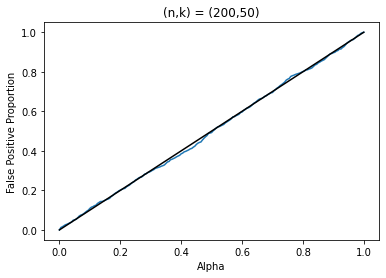

Empirical mean =  0.5023778115628282 . Empirical variance =  0.08355340542701117
Generating plot for (n,k,p) = ( 200 ,  50 ,  )


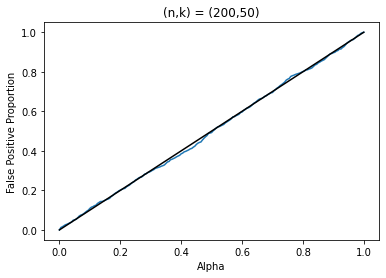

Generating Mann-Whitney plot for (n,k) = ( 500 ,  50 )
Generating plot for (n,k,p) = ( 500 ,  50 ,  1 )


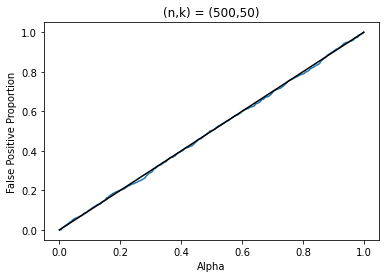

Empirical mean =  0.5025586557365509 . Empirical variance =  0.0839556925080106
Generating plot for (n,k,p) = ( 500 ,  50 ,  )


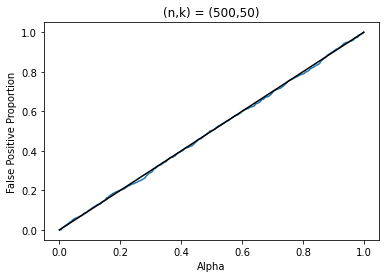

Generating Mann-Whitney plot for (n,k) = ( 100 ,  100 )
Generating plot for (n,k,p) = ( 100 ,  100 ,  1 )


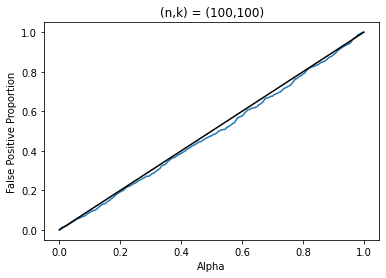

Empirical mean =  0.5141920045171301 . Empirical variance =  0.08364611627825642
Generating plot for (n,k,p) = ( 100 ,  100 ,  )


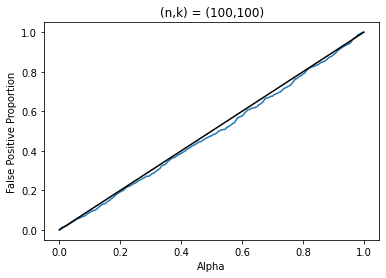

Generating Mann-Whitney plot for (n,k) = ( 200 ,  100 )
Generating plot for (n,k,p) = ( 200 ,  100 ,  1 )


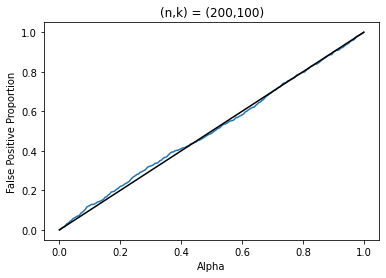

Empirical mean =  0.49616089044918055 . Empirical variance =  0.0879998773813361
Generating plot for (n,k,p) = ( 200 ,  100 ,  )


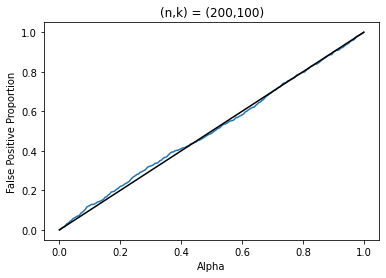

Generating Mann-Whitney plot for (n,k) = ( 500 ,  100 )
Generating plot for (n,k,p) = ( 500 ,  100 ,  1 )


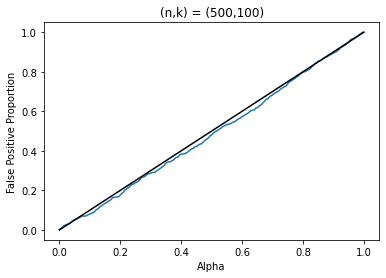

Empirical mean =  0.5138042004685891 . Empirical variance =  0.08197366223204891
Generating plot for (n,k,p) = ( 500 ,  100 ,  )


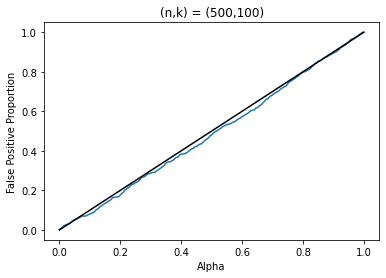

k exceeds n, skipping...
Generating Mann-Whitney plot for (n,k) = ( 200 ,  200 )
Generating plot for (n,k,p) = ( 200 ,  200 ,  1 )


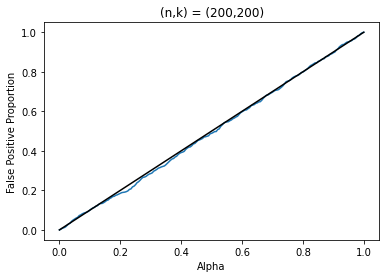

Empirical mean =  0.5056719684092111 . Empirical variance =  0.08174112475697011
Generating plot for (n,k,p) = ( 200 ,  200 ,  )


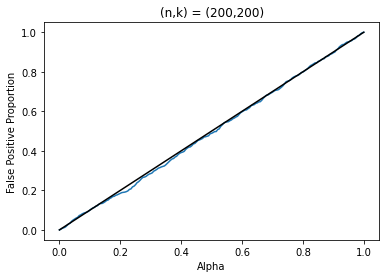

Generating Mann-Whitney plot for (n,k) = ( 500 ,  200 )
Generating plot for (n,k,p) = ( 500 ,  200 ,  1 )


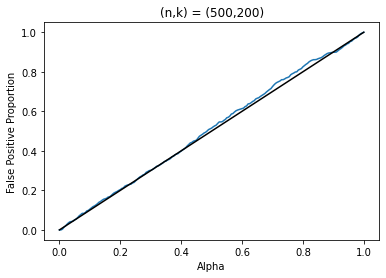

Empirical mean =  0.4909206320575676 . Empirical variance =  0.08128886154475495
Generating plot for (n,k,p) = ( 500 ,  200 ,  )


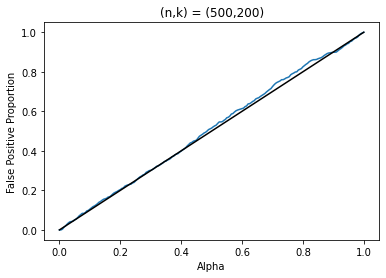

In [8]:
# Mann-Whitney
n_vec = [100,200,500]
k_vec = [50,100,200]
diagnostic_list = pd.DataFrame()


for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF_ALPHA", "FPP_DF_FPP", "PVALUES"])
    k = k_vec[i]
    wList = [i for i in range(k,-1,-1)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating Mann-Whitney plot for (n,k) = (", n,", ",k,")")
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=True, path="type_one_large_n_large_k")
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_mw_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
            
        
    
    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("large_k_large_n_mw_resample.csv")
            
            
            
        

Generating dispersion shift plot for (n,k) = ( 100 ,  50 )
Generating plot for (n,k,p) = ( 100 ,  50 ,  1 )


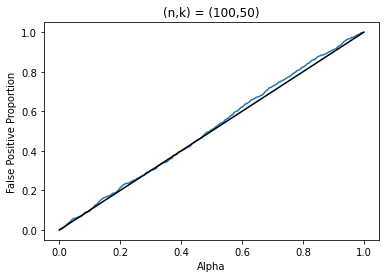

Empirical mean =  0.48924837058568627 . Empirical variance =  0.0798858152236391
Generating plot for (n,k,p) = ( 100 ,  50 ,  )


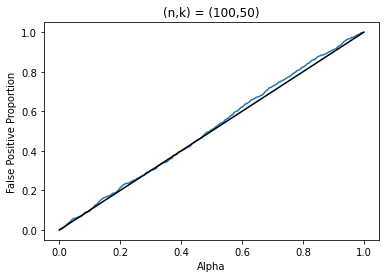

Generating dispersion shift plot for (n,k) = ( 200 ,  50 )
Generating plot for (n,k,p) = ( 200 ,  50 ,  1 )


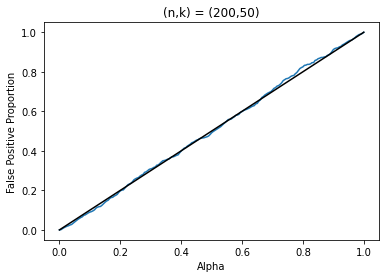

Empirical mean =  0.4985284670214545 . Empirical variance =  0.0802182094885028
Generating plot for (n,k,p) = ( 200 ,  50 ,  )


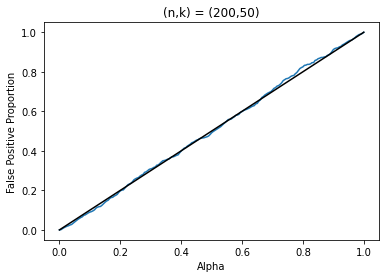

Generating dispersion shift plot for (n,k) = ( 500 ,  50 )
Generating plot for (n,k,p) = ( 500 ,  50 ,  1 )


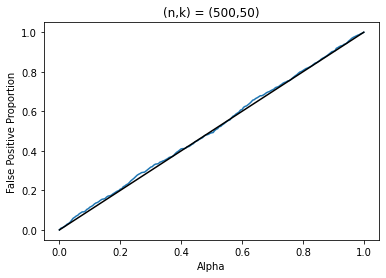

Empirical mean =  0.4931062515566323 . Empirical variance =  0.0844330658839972
Generating plot for (n,k,p) = ( 500 ,  50 ,  )


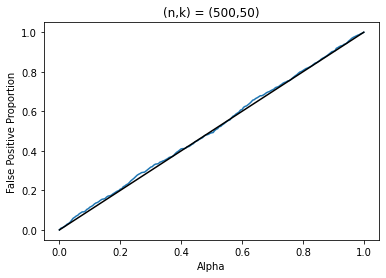

Generating dispersion shift plot for (n,k) = ( 100 ,  100 )
Generating plot for (n,k,p) = ( 100 ,  100 ,  1 )


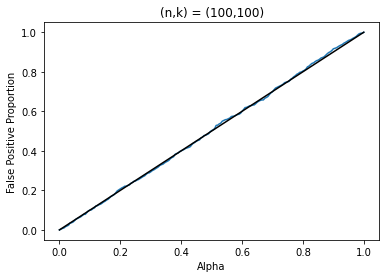

Empirical mean =  0.4987948069990179 . Empirical variance =  0.08128079000671054
Generating plot for (n,k,p) = ( 100 ,  100 ,  )


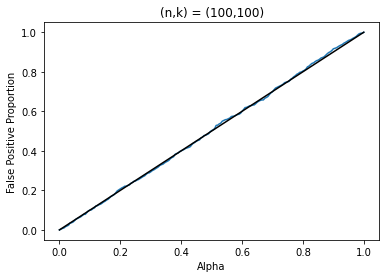

Generating dispersion shift plot for (n,k) = ( 200 ,  100 )
Generating plot for (n,k,p) = ( 200 ,  100 ,  1 )


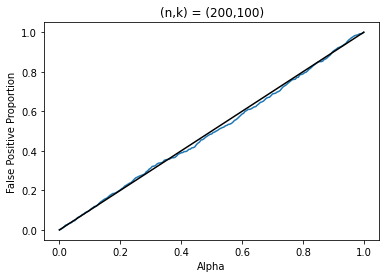

Empirical mean =  0.5050264849381889 . Empirical variance =  0.08503710640880731
Generating plot for (n,k,p) = ( 200 ,  100 ,  )


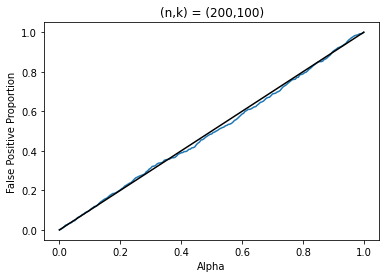

Generating dispersion shift plot for (n,k) = ( 500 ,  100 )
Generating plot for (n,k,p) = ( 500 ,  100 ,  1 )


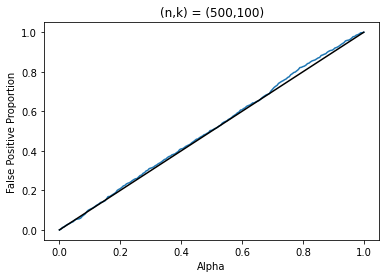

Empirical mean =  0.49124716867950524 . Empirical variance =  0.08052358810572827
Generating plot for (n,k,p) = ( 500 ,  100 ,  )


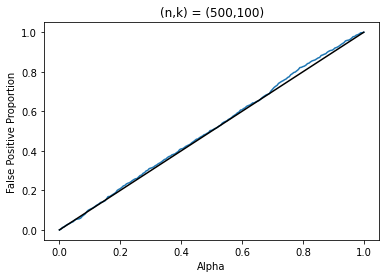

k exceeds n, skipping...
Generating dispersion shift plot for (n,k) = ( 200 ,  200 )
Generating plot for (n,k,p) = ( 200 ,  200 ,  1 )


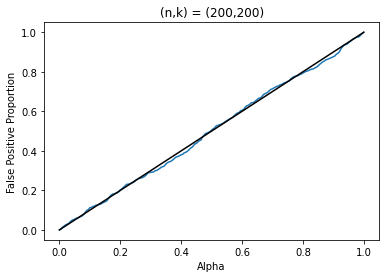

Empirical mean =  0.5029095709687506 . Empirical variance =  0.08423676941992149
Generating plot for (n,k,p) = ( 200 ,  200 ,  )


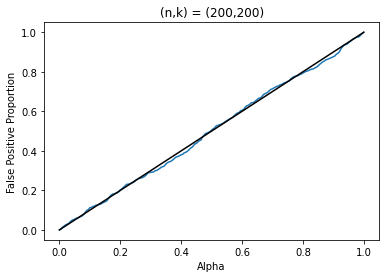

Generating dispersion shift plot for (n,k) = ( 500 ,  200 )
Generating plot for (n,k,p) = ( 500 ,  200 ,  1 )


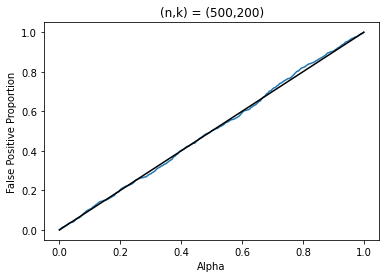

Empirical mean =  0.49882514455107235 . Empirical variance =  0.08105447473968255
Generating plot for (n,k,p) = ( 500 ,  200 ,  )


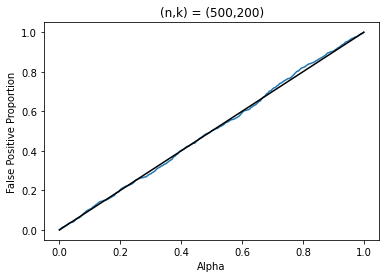

In [9]:
# Scale-shift alternative
n_vec = [100,200,500]
k_vec = [50,100,200]
diagnostic_list = pd.DataFrame()

for i in range(len(k_vec)):
    this_k_list = pd.DataFrame(columns=["EMP_MEAN", "EMP_VAR", "FPP_DF", "PVALUES"])
    k = k_vec[i]
    wList = [(x/(k+1) - 0.5)**2 for x in range(1, k+2)]
    for j in range(len(n_vec)):
        n = n_vec[j]
        if k > n:
            print("k exceeds n, skipping...")
        else:
            print("Generating dispersion shift plot for (n,k) = (", n,", ",k,")")
            mw_check = get_FPR(n=n, k=k, p=1, w_vec=wList, plot=True, path="type_one_large_n_large_k_dispersion")
            print("Empirical mean = ", mw_check["EMP_MEAN"], ". Empirical variance = ", mw_check["EMP_VAR"])
            #this_k_list.append(mw_check)
            
            this_k_list = pd.concat([this_k_list, pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }])])
            
            pd.DataFrame([{
                "EMP_MEAN": mw_check["EMP_MEAN"],
                "EMP_VAR": mw_check["EMP_VAR"],
                "FPP_DF_ALPHA": mw_check["FPP_DF_ALPHA"],
                "FPP_DF_FPP": mw_check["FPP_DF_FPP"],
                "PVALUES": mw_check["PVALUES"]
            }]).to_csv("n"+str(n)+"_k"+str(k)+"_quad_kernel_resample.csv")
            
            print("Generating plot for (n,k,p) = (", n,", ",k,", ",")")
            plt.figure()
            plt.plot(mw_check["FPP_DF_ALPHA"], mw_check["FPP_DF_FPP"])
            plt.title("(n,k) = ("+ str(n)+","+ str(k)+")")
            plt.xlabel("Alpha")
            plt.ylabel("False Positive Proportion")
            plt.plot([0, 1], [0, 1], color='black')
            plt.show()
            
        
    
    #diagnostic_list.append(this_k_list)
    diagnostic_list = pd.concat([diagnostic_list,
        this_k_list
    ])
    
            
diagnostic_list.to_csv("large_k_large_n_quad_kernel_resample.csv")
            
            
            
        
            